In [30]:
import sys
sys.path.append('..')
from pymavlink import mavutil
import matplotlib.pyplot as plt
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point, LineString

from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE

RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

In [31]:
vehiculo = 'DA01'

In [32]:
path_rec = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\SHP\RECORRIDOS_.shp'
gdf_rec = gpd.read_file(path_rec)

In [33]:
if vehiculo == 'DA01':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_01'
elif vehiculo == 'DA02':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_02'
elif vehiculo == 'DA03':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_03'
contenido = os.listdir(path_log)
len(contenido)

158

In [34]:
# Filtrar la lista 'contenido' para excluir elementos que están en la columna 'nombre' del GeoDataFrame
contenido_filtrado = [item for item in contenido if item not in gdf_rec['nombre'].values]
len(contenido_filtrado)

0

In [6]:
def leer_logs(lista_logs):
    list_geo = []
    list_name = []
    for i in lista_logs:
        log = path_log + '/' + i
        
        name = i
        
        mlog = mavutil.mavlink_connection(log)
        lats = []
        lons = []
        while True:
            msg = mlog.recv_match()
            if not msg:
                break
            # Ejemplo de procesamiento de mensaje
            if msg.get_type() == 'GLOBAL_POSITION_INT':
                lat = msg.lat / 1e7  # Latitud en grados
                lon = msg.lon / 1e7  # Longitud en grados
                lats.append(lat)
                lons.append(lon)

        coors = {'lat':lats, 'lon':lons}
        df = pd.DataFrame(coors)
        
        geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
        line = LineString(geometry)
        list_geo.append(line)
        list_name.append(name)
    return (list_geo, list_name)

In [7]:
lineas, names = leer_logs(contenido_filtrado)

In [8]:
lineas

[<LINESTRING (-62.835 -17.413, -62.835 -17.413, -62.835 -17.413, -62.835 -17....>,
 <LINESTRING (-62.838 -17.405, -62.838 -17.405, -62.838 -17.405, -62.838 -17....>,
 <LINESTRING (-62.835 -17.413, -62.835 -17.413, -62.835 -17.413, -62.835 -17....>,
 <LINESTRING (-62.835 -17.413, -62.835 -17.413, -62.835 -17.413, -62.835 -17....>,
 <LINESTRING (-62.83 -17.421, -62.83 -17.421, -62.83 -17.421, -62.83 -17.421,...>,
 <LINESTRING (-62.83 -17.417, -62.83 -17.417, -62.83 -17.417, -62.83 -17.417,...>,
 <LINESTRING (-62.83 -17.417, -62.83 -17.417, -62.83 -17.417, -62.83 -17.417,...>,
 <LINESTRING (-62.83 -17.417, -62.83 -17.417, -62.83 -17.417, -62.83 -17.417,...>,
 <LINESTRING (-62.83 -17.417, -62.83 -17.417, -62.83 -17.417, -62.83 -17.417,...>,
 <LINESTRING (-62.828 -17.405, -62.828 -17.405, -62.828 -17.405, -62.828 -17....>,
 <LINESTRING (-62.809 -17.399, -62.809 -17.399, -62.809 -17.399, -62.809 -17....>,
 <LINESTRING (-62.809 -17.399, -62.809 -17.399, -62.809 -17.399, -62.809 -17....>,
 <LI

In [9]:
# Crear un GeoDataFrame con los LineStrings y sus nombres
gdf_lines = gpd.GeoDataFrame({'nombre': names, 'geometry': lineas}, crs="EPSG:4326")

In [10]:
gdf_lines.head(3)

,nombre,geometry
0,2025-09-16 18-03-42.tlog,"LINESTRING (-62.83505 -17.41316, -62.83505 -17..."
1,2025-09-16 18-14-48.tlog,"LINESTRING (-62.83781 -17.40484, -62.83780 -17..."
2,2025-09-16 18-16-22.tlog,"LINESTRING (-62.83502 -17.41316, -62.83502 -17..."


<Axes: >

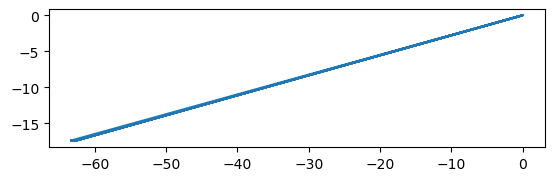

In [11]:
gdf_lines.plot()

In [12]:
gdf_lines.to_file('LINEAS.shp', driver="ESRI Shapefile")

In [13]:
# Función para dividir y limpiar las líneas
def dividir_y_limpiar_linea(linea):
    puntos = list(linea.coords)
    nuevas_lineas = []
    nueva_linea = []
    
    for punto in puntos:
        if punto != (0, 0):
            nueva_linea.append(punto)
        else:
            if nueva_linea:
                nuevas_lineas.append(LineString(nueva_linea))
                nueva_linea = []
    
    if nueva_linea:
        nuevas_lineas.append(LineString(nueva_linea))
    
    return nuevas_lineas

In [14]:
# Crear una lista para las nuevas líneas y nombres
nuevas_lineas = []
nuevos_nombres = []
for idx, row in gdf_lines.iterrows():
    lineas_divididas = dividir_y_limpiar_linea(row.geometry)
    for linea in lineas_divididas:
        nuevas_lineas.append(linea)
        nuevos_nombres.append(row['nombre'])

In [15]:
# Crear un nuevo GeoDataFrame con las nuevas líneas
gdf_lines = gpd.GeoDataFrame({'nombre': nuevos_nombres, 'geometry': nuevas_lineas}, crs="EPSG:4326")

In [16]:
# Función para contar la cantidad de coordenadas en una geometría de tipo LINESTRING
def contar_coordenadas(linea):
    return len(linea.coords)

In [17]:
gdf_lines['num_vert'] = gdf_lines['geometry'].apply(contar_coordenadas)

In [18]:
gdf_lines['vehiculo'] = vehiculo

In [19]:
gdf_lines.head(3)

,nombre,geometry,num_vert,vehiculo
0,2025-09-16 18-03-42.tlog,"LINESTRING (-62.83505 -17.41316, -62.83505 -17...",2042,DA01
1,2025-09-16 18-14-48.tlog,"LINESTRING (-62.83781 -17.40484, -62.83780 -17...",1584,DA01
2,2025-09-16 18-14-48.tlog,"LINESTRING (-62.83501 -17.41315, -62.83501 -17...",100,DA01


<Axes: >

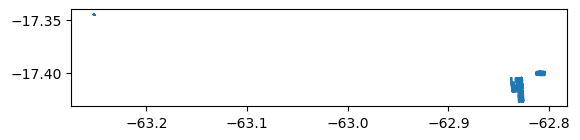

In [20]:
gdf_lines.plot()

In [21]:
gdf_lines.crs = "EPSG:4326"
gdf_lines_utm = gdf_lines.to_crs(epsg=32720)

<Axes: >

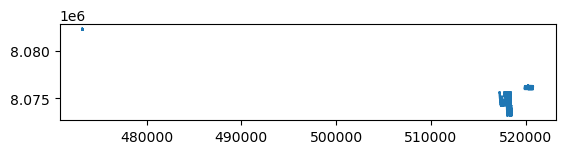

In [22]:
gdf_lines_utm.plot()

In [23]:
# Combinar los GeoDataFrames
gdf_combined = gpd.GeoDataFrame(pd.concat([gdf_rec, gdf_lines_utm], ignore_index=True))
# rellenar valores NaN
gdf_combined['idd'] = gdf_combined['idd'].fillna(0).astype(int)

In [24]:
gdf_combined

,idd,nombre,vehiculo,num_vert,asignado,geometry
0,-1,2025-05-02 08-32-28.tlog,DA02,2517.0,ORIGINAL,"LINESTRING (471873.745 8084797.248, 471873.415..."
1,-1,2025-05-05 16-16-47.tlog,DA02,1056.0,ORIGINAL,"LINESTRING (478886.299 8093597.535, 478886.288..."
2,-1,2025-05-05 16-32-05.tlog,DA02,345.0,ORIGINAL,"LINESTRING (478939.004 8093577.919, 478939.004..."
3,-1,2025-05-05 21-05-04.tlog,DA02,3426.0,ORIGINAL,"LINESTRING (478661.660 8093836.724, 478660.405..."
4,-1,2025-05-05 21-05-04.tlog,DA02,3207.0,ORIGINAL,"LINESTRING (478649.523 8093832.840, 478649.555..."
...,...,...,...,...,...,...
575,0,2025-09-17 07-50-54.tlog,DA01,4110.0,NaN,"LINESTRING (520262.500 8076322.063, 520262.500..."
576,0,2025-09-17 07-50-54.tlog,DA01,177.0,NaN,"LINESTRING (520259.273 8076324.433, 520259.252..."
577,0,2025-09-17 07-50-54.tlog,DA01,341.0,NaN,"LINESTRING (520256.627 8076322.965, 520256.627..."
578,0,2025-09-17 07-50-54.tlog,DA01,148.0,NaN,"LINESTRING (520256.889 8076330.332, 520256.921..."


In [25]:
gdf_combined.dtypes

idd            int32
nombre        object
vehiculo      object
num_vert     float64
asignado      object
geometry    geometry
dtype: object

In [26]:
gdf_combined.to_file(path_rec, driver="ESRI Shapefile")

In [29]:
gdf_combined

,idd,nombre,vehiculo,num_vert,asignado,geometry
0,-1,2025-05-02 08-32-28.tlog,DA02,2517.0,ORIGINAL,"LINESTRING (471873.745 8084797.248, 471873.415..."
1,-1,2025-05-05 16-16-47.tlog,DA02,1056.0,ORIGINAL,"LINESTRING (478886.299 8093597.535, 478886.288..."
2,-1,2025-05-05 16-32-05.tlog,DA02,345.0,ORIGINAL,"LINESTRING (478939.004 8093577.919, 478939.004..."
3,-1,2025-05-05 21-05-04.tlog,DA02,3426.0,ORIGINAL,"LINESTRING (478661.660 8093836.724, 478660.405..."
4,-1,2025-05-05 21-05-04.tlog,DA02,3207.0,ORIGINAL,"LINESTRING (478649.523 8093832.840, 478649.555..."
...,...,...,...,...,...,...
575,0,2025-09-17 07-50-54.tlog,DA01,4110.0,NaN,"LINESTRING (520262.500 8076322.063, 520262.500..."
576,0,2025-09-17 07-50-54.tlog,DA01,177.0,NaN,"LINESTRING (520259.273 8076324.433, 520259.252..."
577,0,2025-09-17 07-50-54.tlog,DA01,341.0,NaN,"LINESTRING (520256.627 8076322.965, 520256.627..."
578,0,2025-09-17 07-50-54.tlog,DA01,148.0,NaN,"LINESTRING (520256.889 8076330.332, 520256.921..."
